# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [1]:
from llm import LLMClient

Then we initialize the client.

In [2]:
client = LLMClient()

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: A detailed explanation of how the query works.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide or example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.
 


---
## First query

Ask method asks a simple query (no discourse mode)

In [6]:
result= client.ask("Give me all the suppliers name from united states")

After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [7]:
print(result.base_prompt)

You are an AI tasked with converting natural language descriptions into PyDough code snippets. You will be provided with two reference files: 

1. **PyDough Reference File** - This file contains the core concepts, functions, and syntax of PyDough.
{script_content}

2. **Database Structure Reference File** - This file outlines the database schema, collections, fields, and relationships.
{database_content}

3. **Examples for Context:** Here are some examples of PyDough code snippets along with their corresponding natural language questions that are similar to the user's query. These examples will help contextualize the task and guide you in understanding the user's requirements. Analyze if those examples are relevant to the user's query by comparing their structure, intent, and expected output. If the examples closely match the user's request, they can serve as a reference for constructing an appropriate PyDough query.

{similar_queries}

Your objective is to analyze the provided natural

We can also ask for the for the **pydough code** directly.

In [8]:
print(result.code)

us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [9]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    _table_alias_0.name AS name,
    _table_alias_1.name AS name_3
  FROM (
    SELECT
      s_name AS name,
      s_nationkey AS nation_key
    FROM main.SUPPLIER
  ) AS _table_alias_0
  LEFT JOIN (
    SELECT
      n_nationkey AS key,
      n_name AS name
    FROM main.NATION
  ) AS _table_alias_1
    ON nation_key = key
)
WHERE
  name_3 = 'UNITED STATES'


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [10]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get a simple **explanation** of the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [11]:
print(result.full_explanation)



```python
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
```

Step-by-step explanation:
1. Start with the `suppliers` collection from the database schema
2. Filter using `.WHERE()` to only keep suppliers where their nation's name equals "UNITED STATES"
3. Use `.CALCULATE()` to select/rename the name field as `supplier_name`
4. Assign the result to variable `us_suppliers`

This follows PyDough best practices by:
- Filtering before calculation for efficiency
- Using explicit field naming in CALCULATE
- Maintaining consistent dot-notation navigation (suppliers → nation → name)
- Avoiding unnecessary PARTITION since we're not grouping/aggregating
- Using a clear variable name that's different from the raw field names


We can also check the original natural language **question** that was asked.

In [12]:
print(result.original_question)

Give me all the suppliers name from united states


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [13]:
print(result.cheat_sheet)

# **PYDOUGH CHEAT SHEET**  
This cheat sheet is a context for learning how to create PyDough code. You must follow all the written rules. Each section represents important features and rules to keep in mind when developing PyDough code. 

## **GENERAL RULES**: 

  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - PARTITION function ALWAYS need 3 parameters `Collection, name and by`. The “by” parameter must never have collections, subcollections or calculations. Any required variable or value must have been previously calculated, because the parameter only accept expressions. 

  - Always keep in mind the order of the query. For example, if I tell you to give me the name and the phone_number, give them to me in this order, first the “name” column and then the “phone_number” column. 

  - In PyDough, complex calculations can often be expressed concisely by combining filters, transformations, and aggreg

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

In [3]:
result= client.ask("For each of the 5 largest part sizes, find the part of that size with the largest retail price")

print(result.full_explanation)



To solve this problem, we need to identify the top 5 largest part sizes and then find the part with the highest retail price within each of those sizes. 

### Approach
1. **Identify Top Sizes**: First, determine the 5 largest distinct part sizes using the `PARTITION` function to group parts by size and select the top 5 based on descending size.
2. **Filter Parts by Top Sizes**: Filter the parts to include only those with the identified top sizes.
3. **Find Highest-Priced Part per Size**: For each of these sizes, use `PARTITION` again to group parts by size and then select the part with the highest retail price within each group using `TOP_K`.

### Solution Code
```python
# Identify the top 5 largest part sizes
top_sizes = (
    PARTITION(parts, name='size_group', by=size)
    .CALCULATE(size=size)
    .ORDER_BY(size.DESC())
    .TOP_K(5, by=size.DESC())
)

# For each top size, find the part with the highest retail price
result = (
    parts.WHERE(size.ISIN(top_sizes.size))
    .PARTI

If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [4]:
print(result.exception)

An error occurred while processing the code: PyDough nodes size.ISIN is not callable. Did you mean to use a function?


You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [5]:
corrected_result = client.correct(result)

To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [6]:
print(corrected_result.code)

# Get the 5 largest distinct part sizes using aggregation-safe method
top_sizes = (
    parts.CALCULATE(size=size)
    .ORDER_BY(size.DESC())
    .TOP_K(5, by=size.DESC())
)

# For each of the top sizes, find the part with highest retail price
result = (
    PARTITION(
        parts.WHERE(ISIN(size, top_sizes.size)),
        name='size_group', 
        by=size
    )
    .CALCULATE(
        size=size,
        part_name=name,
        retail_price=retail_price
    )
    .TOP_K(1, by=retail_price.DESC())
    .ORDER_BY(size.DESC())
)


---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [19]:
result= client.ask("Give me all the order prices, name the column total_price")

result.df

,total_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


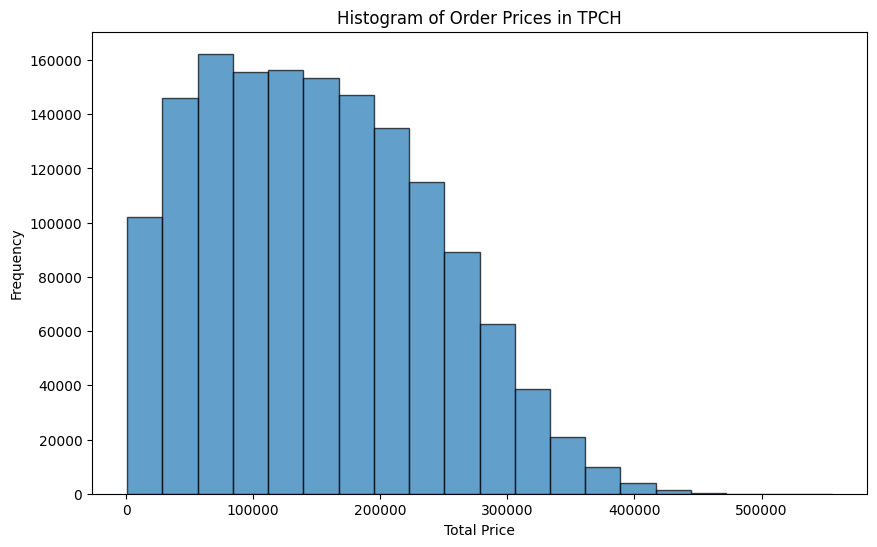

In [20]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["total_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

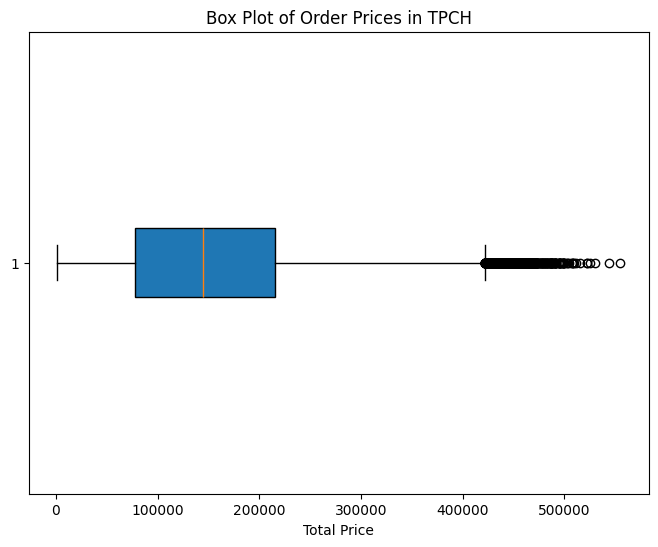

In [22]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["total_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [23]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Now, this can be used to analyse the PyDough code that was first generated.

{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


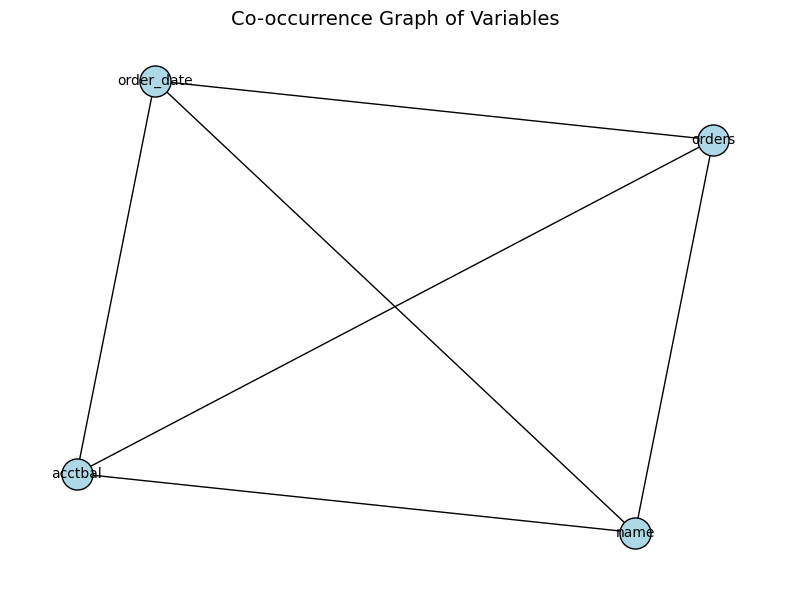

In [24]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)


---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [25]:
query= "Find the names of all customers and the number of orders placed in 1995 in Europe."

result= client.ask(query)

print(result.full_explanation)
result.df.head()



```python
# Find customers in Europe and count their 1995 orders
customer_data = customers.WHERE(
    nation.region.name == "EUROPE"
).CALCULATE(
    customer_name=name,
    order_count=COUNT(orders.WHERE(YEAR(order_date) == 1995))
)
```

**Step-by-Step Explanation:**

1. **Filter Customers by Region**:
   - `WHERE(nation.region.name == "EUROPE")` restricts results to customers located in Europe by checking their linked nation's region name

2. **Calculate Required Fields**:
   - `customer_name=name` preserves the customer's name
   - `order_count=COUNT(orders.WHERE(...))` calculates the number of orders:
     - `YEAR(order_date) == 1995` filters orders to only those from 1995
     - `COUNT()` aggregates the filtered orders

3. **Output Structure**:
   - Returns a collection with two columns: customer_name and order_count
   - Maintains one row per European customer, including those with 0 orders in 1995

**Key Compliance Notes:**
- Uses hierarchical filtering instead of PARTITION
- 

,customer_name,order_count
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [26]:
result= client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result.full_explanation)
result.df.head()



```python
# Find European customers with account balance > $700 and at least one 1995 order, sorted by order count
customer_data = customers.WHERE(
    nation.region.name == "EUROPE"
).CALCULATE(
    customer_name=name,
    acctbal=acctbal,
    order_count=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (acctbal > 700) & (order_count >= 1)
).ORDER_BY(
    order_count.DESC()
)
```

**Step-by-Step Explanation:**  
1. **Filter Scope**: Start with all customers in Europe using `.WHERE(nation.region.name == "EUROPE")`  
2. **Calculate Fields**:  
   - Keep customer name and account balance  
   - Count orders from 1995 using a nested filter in `COUNT()`  
3. **Apply Filters**:  
   - Keep only customers with account balance > $700 (`acctbal > 700`)  
   - Require at least 1 order from 1995 (`order_count >= 1`)  
4. **Sort Results**: Order descending by order count using `.ORDER_BY(order_count.DESC())`  

This builds directly on the previous solution while maintaining all PyDoug

,customer_name,acctbal,order_count
0,Customer#000107440,2464.61,12
1,Customer#000014920,7026.03,11
2,Customer#000079606,989.51,11
3,Customer#000108496,7388.38,11
4,Customer#000009019,2247.06,10


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [30]:
query= "List customers who ordered in 1996 but not in 1997 with a total spent of over 1000$ If you use HAS add a ==1"

result= client.ask(query)

print(result.full_explanation)
result.df.head()



```python
# Calculate total 1996 spending and check order years for each customer
result = customers.CALCULATE(
    # Filter for customers with 1996 orders using explicit HAS comparison
    ordered_in_1996=HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1,
    
    # Check for absence of 1997 orders using HAS comparison
    ordered_in_1997=HAS(orders.WHERE(YEAR(order_date) == 1997)) == 1,
    
    # Sum total price of 1996 orders using aggregation
    total_spent=SUM(
        orders.WHERE(YEAR(order_date) == 1996).total_price
    ),
    
    # Keep original customer identifiers
    cust_key=key,
    cust_name=name
).WHERE(
    # Apply final filters
    (ordered_in_1996 == True) & 
    (ordered_in_1997 == False) & 
    (total_spent > 1000)
).CALCULATE(  # Final projection
    cust_key=cust_key,
    cust_name=cust_name,
    total_spent=total_spent
)
```

Step-by-step explanation:
1. **Order Verification**: For each customer, we calculate:
   - `ordered_in_1996` using HAS() with explicit

,cust_key,cust_name,total_spent
0,5,Customer#000000005,98790.79
1,17,Customer#000000017,481076.02
2,20,Customer#000000020,538764.56
3,31,Customer#000000031,720459.29
4,38,Customer#000000038,788657.01


**Follow up**: Include the number of months since the last order and sort by total spent, highest first.

In [31]:
result2= client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result2.full_explanation)
result2.df.head() 



```python
# Calculate total spending and temporal metrics for qualified customers
final_result = customers.CALCULATE(
    # 1996 order presence check
    ordered_in_1996=HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1,
    
    # 1997 order absence check
    ordered_in_1997=HAS(orders.WHERE(YEAR(order_date) == 1997)) == 1,
    
    # Total spending calculation for 1996 orders
    total_spent=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    
    # Get latest order date from 1996 orders
    last_order=MAX(orders.WHERE(YEAR(order_date) == 1996).order_date),
    
    # Preserve customer identifiers
    cust_key=key,
    cust_name=name
).WHERE(
    # Apply qualifying filters
    (ordered_in_1996 == True) & 
    (ordered_in_1997 == False) & 
    (total_spent > 1000)
).CALCULATE(
    # Final projection with temporal calculation
    cust_key=cust_key,
    cust_name=cust_name,
    total_spent=total_spent,
    
    # Calculate months since last order using DATEDIFF
    months_sinc

,cust_key,cust_name,total_spent,months_since
0,1948,Customer#000001948,1785971.27,339
1,57892,Customer#000057892,1668071.25,339
2,111028,Customer#000111028,1626293.12,340
3,112711,Customer#000112711,1623258.35,341
4,113131,Customer#000113131,1597282.31,339


### Sales Performance

### 3. Find the region name with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [33]:
query="""Find the region name with the highest total order value in 1996. 
The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)"""

result= client.ask(query)

print(result.full_explanation)
result.df.head()



To solve this problem, we need to determine the region with the highest total order value in 1996. The total order value is calculated as the sum of `extended_price * (1 - discount)` for all relevant line items. Here's how we can approach this step-by-step using PyDough:

```python
# Calculate total revenue per region from 1996 orders
highest_value_region = (
    PARTITION(
        # Filter lines from 1996 orders and calculate potential revenue
        lines.WHERE(YEAR(order.order_date) == 1996).CALCULATE(
            potential_revenue=extended_price * (1 - discount),
            region_name=order.customer.nation.region.name
        ),
        name='regional_lines', 
        by=region_name
    ).CALCULATE(
        # Aggregate revenue by region
        region_name=region_name,
        total_revenue=SUM(regional_lines.potential_revenue)
    )
    # Select region with highest total revenue
    .TOP_K(1, by=total_revenue.DESC())
)
```

**Step-by-Step Explanation:**

1. **Filter 1996 Orde

,region_name,total_revenue
0,EUROPE,6.746079e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

Highlights ranking queries (TOP_K()), customer segmentation, and purchasing trends. 

In [34]:
query= "Which 10 customers purchased the highest quantity of products during 1998?"

result= client.ask(query)

print(result.full_explanation)
result.df.head()



```python
top_customers_1998 = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(
        orders.WHERE(YEAR(order_date) == 1998)
        .lines.CALCULATE(qty=quantity).qty
    )
).TOP_K(10, by=total_quantity.DESC())
```

**Step-by-Step Explanation:**

1. **Filter 1998 Orders:**  
   `orders.WHERE(YEAR(order_date) == 1998)` selects only orders placed in 1998.

2. **Extract Line Item Quantities:**  
   `.lines.CALCULATE(qty=quantity)` isolates the quantity field from each line item using CALCULATE to avoid subcollection chaining.

3. **Sum Quantities per Customer:**  
   `SUM(...)` aggregates all line item quantities across a customer's filtered orders.

4. **Calculate Customer Metrics:**  
   `CALCULATE(customer_name=name, total_quantity=...)` preserves customer names while adding their total purchased quantities.

5. **Select Top 10:**  
   `.TOP_K(10, by=total_quantity.DESC())` sorts customers by descending total quantity and keeps only the top 10.

This solution a

,customer_name,total_quantity
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058


**Follow up**: Now only the ones that have "green" on the product name.

In [35]:
result= client.discourse(result, "Only the ones that have 'green' on the product name.")

print(result.full_explanation)
result.df.head()



```python
top_customers_1998_green = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(
        orders.WHERE(YEAR(order_date) == 1998)
        .lines.WHERE(CONTAINS(LOWER(part.name), 'green'))
        .CALCULATE(qty=quantity).qty
    )
).TOP_K(10, by=total_quantity.DESC())
```

**Step-by-Step Explanation:**
1. **Filter 1998 Orders:** First limit orders to those placed in 1998 using `YEAR(order_date)`
2. **Green Product Filter:** Add a nested filter on line items to only include parts with 'green' in their name using:
   - `CONTAINS(LOWER(...))` for case-insensitive match
   - Access part names via `part.name` relationship
3. **Quantity Calculation:** Maintain the existing quantity aggregation pattern but now only for green products:
   - Extract quantities from filtered line items
   - Sum quantities at customer level
4. **Top 10 Selection:** Keep the TOP_K(10) pattern but now works with green-product quantities

This adds the 'green' filter at the line item level w

,customer_name,total_quantity
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172


### Revenue Performance (WIP)

### 5. What is the february 1996 SPM for the almond antique blue royal burnished part in China?

- SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100
- This query was provided as a representative example of potential stakeholder inquiries.
- Showcases advanced partitioning and filtering, demonstrating how PyDough can be used for highly specific business KPIs. 
- Compare with a previous time period and exclude/include specific suppliers, making it a progressive data exploration example.

In [39]:
query= """What is the february 1996 SPM for the almond antique blue royal burnished part in China? 
SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100"""

result= client.ask(query)

print(result.full_explanation)



```python
# Calculate SPM for almond antique blue royal burnished parts in China during Feb 1996
feb_1996_spm = (
    lines.WHERE(
        (part.name == "almond antique blue royal burnished") &
        (YEAR(order.order_date) == 1996) &
        (MONTH(order.order_date) == 2) &
        (order.customer.nation.name == "China")
    )
    .CALCULATE(
        total_sales=SUM(extended_price),
        total_costs=SUM(tax + discount)  # Using discount as commission proxy
    )
    .CALCULATE(
        spm=(total_sales - total_costs) / total_sales * 100
    )
)
```

**Step-by-Step Explanation:**

1. **Filter Relevant Lines:**
   - Filter line items for parts named "almond antique blue royal burnished"
   - Filter orders from February 1996 using YEAR/MONTH functions
   - Filter customers located in China using nation name

2. **Calculate Aggregates:**
   - `total_sales`: Sum of extended prices for qualifying line items
   - `total_costs`: Sum of tax + discount (using discount as commission proxy

**Follow up**: Compare that to november 1995 SPM, have we seen an increase?

In [ ]:
result= client.discourse(result, "Compare that to november 1995 SPM, have we seen an increase?")

print(result.full_explanation)



```python
# Define filter conditions and calculations for February 1996
feb_1996_spm = (
    lines.WHERE(
        (part.name == 'almond antique blue royal burnished') &
        (order.customer.nation.name == 'China') &
        (YEAR(order.order_date) == 1996) &
        (MONTH(order.order_date) == 2)
    )
    .CALCULATE(
        total_sales=SUM(extended_price * (1 - discount)),
        total_tax=SUM(tax),
        total_cost=SUM(part_and_supplier.supplycost * quantity)
    )
    .CALCULATE(
        spm=(total_sales - (total_tax + total_cost)) / total_sales * 100
    )
)

# Define filter conditions and calculations for November 1995
nov_1995_spm = (
    lines.WHERE(
        (part.name == 'almond antique blue royal burnished') &
        (order.customer.nation.name == 'China') &
        (YEAR(order.order_date) == 1995) &
        (MONTH(order.order_date) == 11)
    )
    .CALCULATE(
        total_sales=SUM(extended_price * (1 - discount)),
        total_tax=SUM(tax),
        total_cost=SU

**Follow up**: Now exclude supplier Supplier#000001305 and focus only on supplier Supplier#000008802

In [42]:
result= client.discourse(result, """Now exclude supplier Supplier#000001305 
                         and focus only on supplier Supplier#000008802v""")

print(result.full_explanation)



```python
# Updated February 1996 calculation with supplier filters
feb_1996_spm = (
    lines.WHERE(
        (part.name == 'almond antique blue royal burnished') &
        (order.customer.nation.name == 'China') &
        (YEAR(order.order_date) == 1996) &
        (MONTH(order.order_date) == 2) &
        (supplier_key != 'Supplier#000001305') &  # Exclude specified supplier
        (supplier_key == 'Supplier#000008802')    # Focus on specific supplier
    )
    .CALCULATE(
        total_sales=SUM(extended_price * (1 - discount)),
        total_tax=SUM(tax),
        total_cost=SUM(part_and_supplier.supplycost * quantity)
    )
    .CALCULATE(
        spm=(total_sales - (total_tax + total_cost)) / total_sales * 100
    )
)

# Updated November 1995 calculation with supplier filters
nov_1995_spm = (
    lines.WHERE(
        (part.name == 'almond antique blue royal burnished') &
        (order.customer.nation.name == 'China') &
        (YEAR(order.order_date) == 1995) &
        (MONTH(or